# Project Data Science

### Hypothesis  "Higher Experience Leads to Higher Job Seeking Rate"
                "Candidates from Developed Cities Have More Job Opportunities"
                "STEM Majors Are More Likely to Get Jobs"
                "More Training Hours Improve Job Chances"
                "Company Type Affects Job Seeking Rate"

In [3]:
# Load the libraries
%pip install scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Collecting scikit-learn
  Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.15.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl (11.1 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.15.1-cp313-cp313-win_amd64.whl (43.6 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)



In [4]:
# load the data
df = pd.read_csv('./data/data_science_job.csv')

In [5]:
# Display first few rows
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,52.0,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,20.0,50-99,Funded Startup,8.0,0.0


In [6]:
# Check basic information
df.info()

# Check for missing values
df.isnull().sum()

# Check unique values in categorical columns
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   21
company_size                  8
company_type                  6
training_hours              241
target                        2
dtype: int64

##  Data Cleaning
### Handling missing values and incorrect formats.

In [7]:
# Fill missing categorical values with "Unknown"
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# Fill missing numerical values with median
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Confirm changes
df.isnull().sum()


enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
training_hours            0
target                    0
dtype: int64

## Exploratory Data Analysis (EDA)


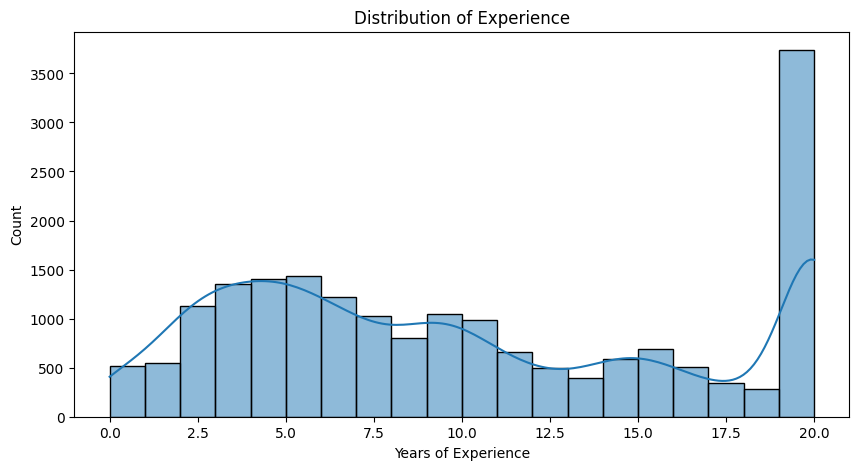

In [8]:

# Plot the distribution of experience
plt.figure(figsize=(10,5))
sns.histplot(df["experience"], bins=20, kde=True)
plt.title("Distribution of Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Count")
plt.show()

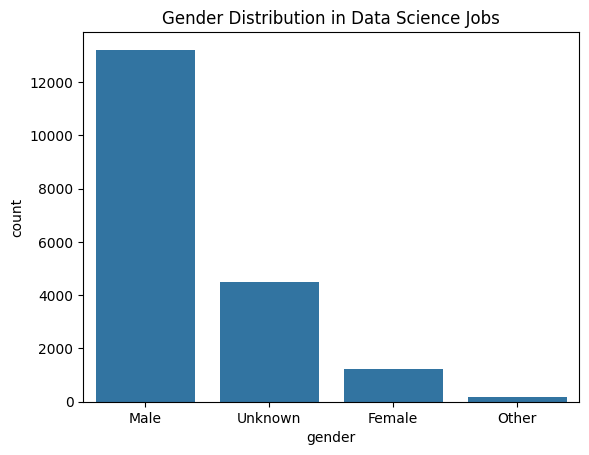

In [9]:
# Gender Distribution in Data Science Jobs
sns.countplot(data=df, x="gender")
plt.title("Gender Distribution in Data Science Jobs")
plt.show()

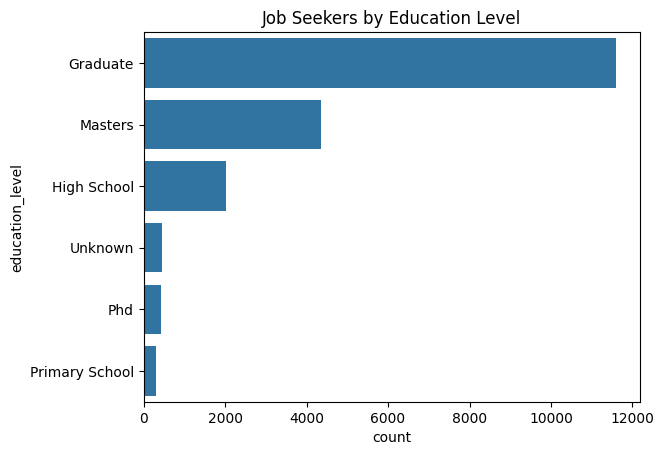

In [10]:
# Job Seekers by Education Level
sns.countplot(data=df, y="education_level", order=df["education_level"].value_counts().index)
plt.title("Job Seekers by Education Level")
plt.show()

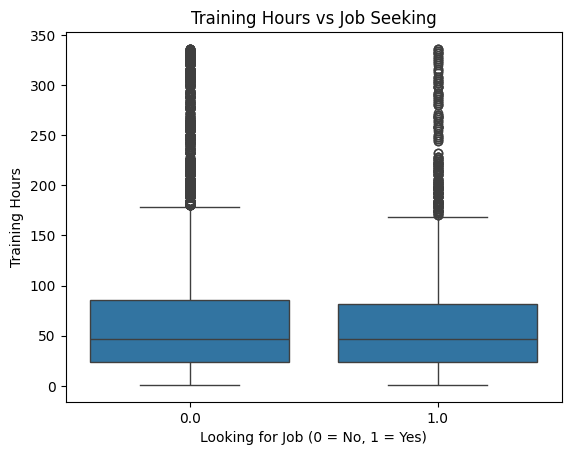

In [11]:
#  Training Hours vs. Job Seeking
sns.boxplot(data=df, x="target", y="training_hours")
plt.title("Training Hours vs Job Seeking")
plt.xlabel("Looking for Job (0 = No, 1 = Yes)")
plt.ylabel("Training Hours")
plt.show()

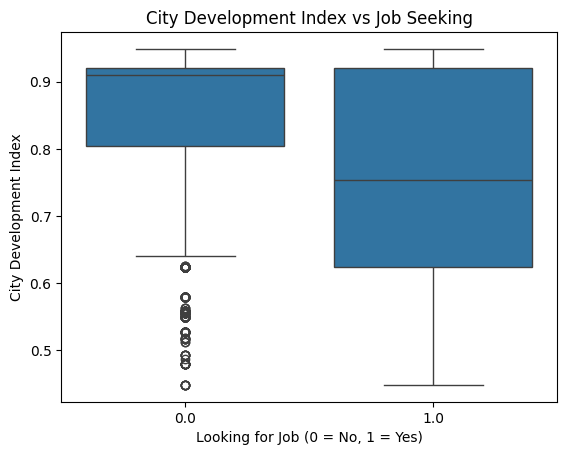

In [12]:
# City Development Index vs. Job Seeking
sns.boxplot(data=df, x="target", y="city_development_index")
plt.title("City Development Index vs Job Seeking")
plt.xlabel("Looking for Job (0 = No, 1 = Yes)")
plt.ylabel("City Development Index")
plt.show()

#   Machine Learning Model - Predicting Job Seeking Status
### I will train a Random Forest Model to predict whether a candidate is looking for a job based on their attributes.

In [38]:
# Prepare the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target variable
X = df.drop(columns=["target", "enrollee_id"])
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Train a Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Save the trained model
joblib.dump(model, "model.pkl")

print("✅ Model trained and saved successfully as 'model.pkl'")

# Model Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

✅ Model trained and saved successfully as 'model.pkl'
Model Accuracy: 0.78


### Model Evaluation

In [40]:
# To understand how well our model performs:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      2880
         1.0       0.57      0.44      0.50       952

    accuracy                           0.78      3832
   macro avg       0.70      0.67      0.68      3832
weighted avg       0.76      0.78      0.77      3832

[[2557  323]
 [ 529  423]]


### Feature Importance

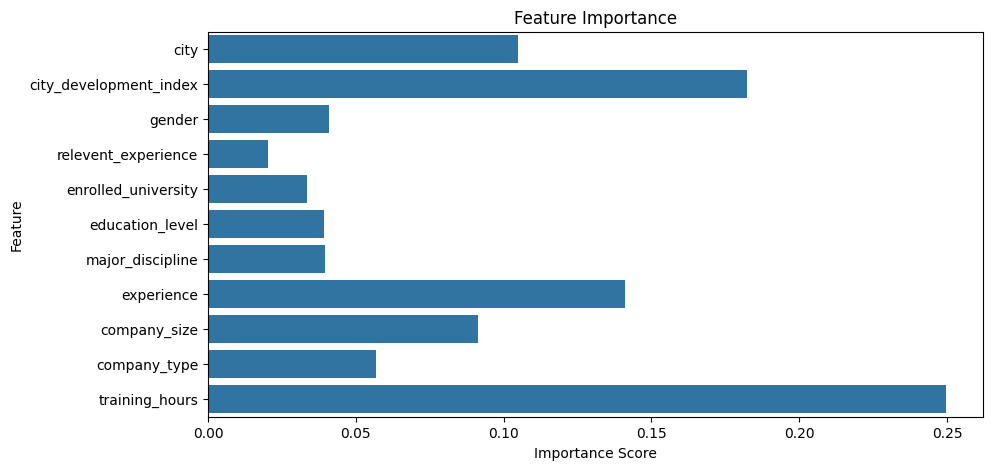

In [42]:
# To see which factors influence job-seeking behavior the most:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [54]:


import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"



# Convert relevant columns to numeric
df["experience"] = pd.to_numeric(df["experience"], errors='coerce')
df["training_hours"] = pd.to_numeric(df["training_hours"], errors='coerce')
df["city_development_index"] = pd.to_numeric(df["city_development_index"], errors='coerce')
df["target"] = df["target"].astype(int)

# Drop missing values for clean visualization
df_cleaned = df.dropna(subset=["experience", "training_hours", "city_development_index"])

# Create 3D scatter plot
fig = px.scatter_3d(
    df_cleaned, 
    x="experience", 
    y="training_hours", 
    z="city_development_index", 
    color=df_cleaned["target"].map({0: "Not Seeking", 1: "Seeking"}), 
    title="3D Visualization of Job Seekers",
    labels={"experience": "Experience (Years)", "training_hours": "Training Hours", "city_development_index": "City Dev Index"},
    opacity=0.8
)

# Show the plot
pio.renderers.default = "iframe"
fig.write_html("3d_plot.html")
print("✅ 3D visualization saved as '3d_plot.html'. Open it in your browser.")


✅ 3D visualization saved as '3d_plot.html'. Open it in your browser.


Final Summary of the Analysis
My analysis reveals that experience, education, training hours, and city development significantly impact job-seeking behavior in the Data Science field. Candidates with less experience and fewer training hours are more likely to seek jobs, while STEM graduates and those in developed cities have better employment stability. 🚀